In [1]:
import codecs
import glob
import logging
import multiprocessing
import os
import pprint
import re

import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
book_filenames = sorted(glob.glob('work/intro_deep_learning/35_got/*.txt'))

print("Found books:")
book_filenames

Found books:


['work/intro_deep_learning/35_got/got1.txt',
 'work/intro_deep_learning/35_got/got2.txt',
 'work/intro_deep_learning/35_got/got3.txt',
 'work/intro_deep_learning/35_got/got4.txt',
 'work/intro_deep_learning/35_got/got5.txt']

In [4]:
corpus_raw = u""
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print()

Reading 'work/intro_deep_learning/35_got/got1.txt'...
Corpus is now 1768668 characters long

Reading 'work/intro_deep_learning/35_got/got2.txt'...
Corpus is now 4065922 characters long

Reading 'work/intro_deep_learning/35_got/got3.txt'...
Corpus is now 6381343 characters long

Reading 'work/intro_deep_learning/35_got/got4.txt'...
Corpus is now 8093696 characters long

Reading 'work/intro_deep_learning/35_got/got5.txt'...
Corpus is now 9703282 characters long



In [6]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
raw_sentences = tokenizer.tokenize(corpus_raw)

In [7]:

#convert into a list of words
#rtemove unnnecessary,, split into words, no hyphens
#list of words
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [8]:
#sentence where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [9]:
print(raw_sentences[5])
print(sentence_to_wordlist(raw_sentences[5]))

Now he thought of them as old friends.
['Now', 'he', 'thought', 'of', 'them', 'as', 'old', 'friends']


In [10]:
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 1,815,535 tokens


In [23]:
#ONCE we have vectors
#step 3 - build model
#3 main tasks that vectors help with
#DISTANCE, SIMILARITY, RANKING

# Dimensionality of the resulting word vectors.
#more dimensions, more computationally expensive to train
#but also more accurate
#more dimensions = more generalized
num_features = 300
# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.
#more workers, faster we train
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 7

# Downsample setting for frequent words.
#0 - 1e-5 is good for this
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
#random number generator
#deterministic, good for debugging
seed = 1


thrones2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [24]:
thrones2vec.build_vocab(sentences)
print (thrones2vec)
# print("Word2Vec vocabulary length:", len(thrones2vec.vocab))

Word2Vec(vocab=17178, size=300, alpha=0.025)


In [25]:
thrones2vec.train(sentences, total_examples=thrones2vec.corpus_count, epochs=thrones2vec.epochs) # add total_examples, epocs

(7009981, 9077675)

In [26]:
if not os.path.exists("trained"):
    os.makedirs("trained")

thrones2vec.save(os.path.join("trained", "thrones2vec.w2v"))

In [27]:
thrones2vec = w2v.Word2Vec.load(os.path.join("trained", "thrones2vec.w2v"))

In [28]:
#my video - how to visualize a dataset easily
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [31]:
all_word_vectors_matrix = thrones2vec.wv.vectors # different

In [32]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [37]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[thrones2vec.wv.vocab[word].index])
            for word in thrones2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [39]:
points.head(10)

,word,x,y
0,PROLOGUE,-4.455624,-1.918470
1,The,-0.427733,10.672731
2,comet,-46.145962,25.348574
3,s,41.020626,-12.182321
4,tail,-19.550333,38.906826
5,spread,-25.266848,29.119493
6,across,-23.774759,30.148869
7,the,-0.562410,10.741377
8,dawn,-23.186354,25.937843
9,a,-7.468946,25.197443


In [40]:
sns.set_context('poster')

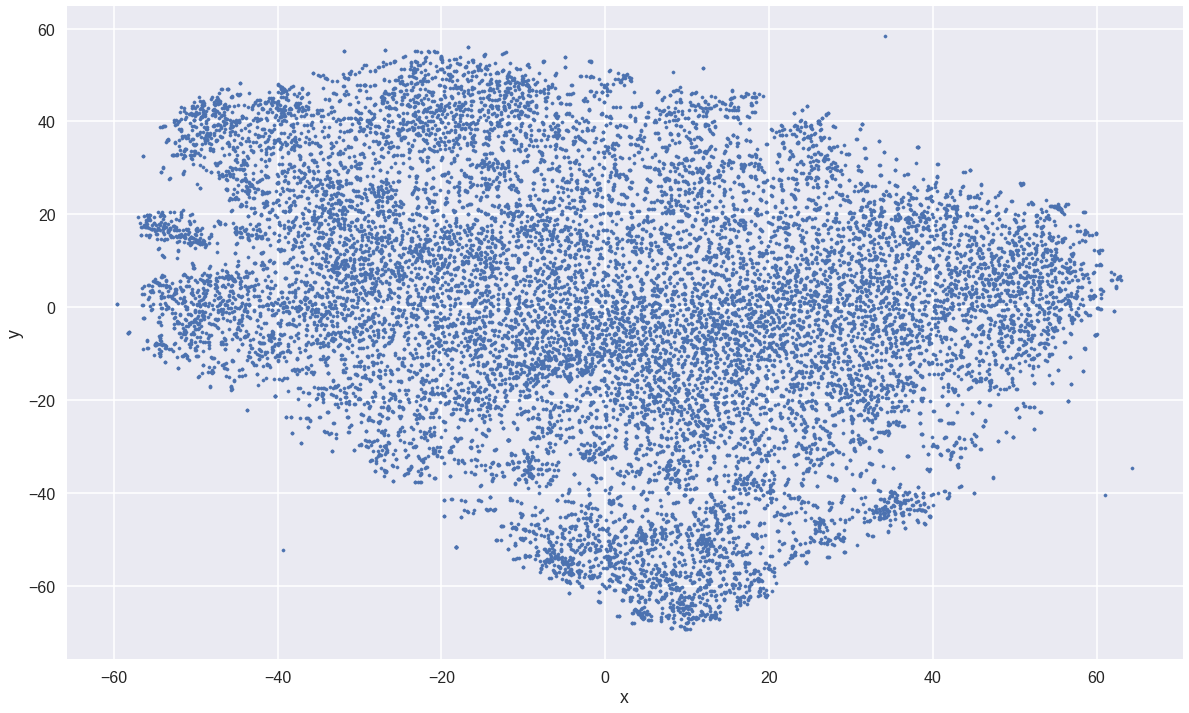

In [41]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [71]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

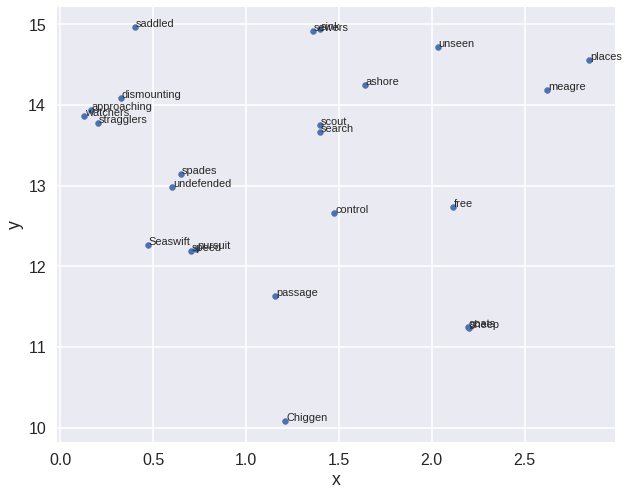

In [72]:
# plot_region(x_bounds=(4.0, 4.2), y_bounds=(-0.5, -0.1))
plot_region(x_bounds=(0, 3), y_bounds=(10, 15))

In [61]:
thrones2vec.wv.most_similar("Stark")

[('Eddard', 0.729623556137085),
 ('Winterfell', 0.6560367345809937),
 ('Lyanna', 0.6461813449859619),
 ('Rickard', 0.623858630657196),
 ('North', 0.6235990524291992),
 ('beheaded', 0.6220386624336243),
 ('Benjen', 0.6210166811943054),
 ('CATELYN', 0.6164411306381226),
 ('Karstark', 0.6161649227142334),
 ('executed', 0.6120902299880981)]

In [62]:
thrones2vec.wv.most_similar("direwolf")

[('wolf', 0.6600787043571472),
 ('Rickon', 0.6426627039909363),
 ('SHAGGYDOG', 0.6347167491912842),
 ('pup', 0.6257439851760864),
 ('Ghost', 0.6231039762496948),
 ('eagle', 0.6151823997497559),
 ('GHOST', 0.6132882833480835),
 ('Reed', 0.606304407119751),
 ('Robb', 0.6061536073684692),
 ('Stark', 0.6035724878311157)]

In [66]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = thrones2vec.wv.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [67]:

nearest_similarity_cosmul("Stark", "Winterfell", "Riverrun")
nearest_similarity_cosmul("Jaime", "sword", "wine")
nearest_similarity_cosmul("Arya", "Nymeria", "dragons")

Stark is related to Winterfell, as Cleos is related to Riverrun
Jaime is related to sword, as Tyrion is related to wine
Arya is related to Nymeria, as Daenerys is related to dragons


'Daenerys'